<a href="https://colab.research.google.com/github/KarmanyaGupta1421/Compfinance/blob/main/comp_finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [45]:
api_key = 'MOI7PA5VCAQ9ADCP'
symbol = 'IBM'
interval = '1min'

In [46]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&outputsize=full&apikey={api_key}&datatype=json'
# print(url)

response = requests.get(url)
data = response.json()
time_series = data[f"Time Series ({interval})"]

In [47]:
df = pd.DataFrame.from_dict(time_series, orient="index")
df.columns = ["Open", "High", "Low", "Close", "Volume"]
df.index = pd.to_datetime(df.index)
df = df.astype(float)
print(df.head())

                       Open    High     Low   Close  Volume
2024-06-14 19:59:00  169.15  169.16  169.15  169.16   217.0
2024-06-14 19:51:00  169.16  169.16  169.16  169.16     2.0
2024-06-14 19:50:00  169.19  169.19  169.19  169.19    10.0
2024-06-14 19:45:00  169.06  169.06  169.06  169.06     1.0
2024-06-14 19:40:00  169.07  169.07  169.06  169.06    50.0


In [48]:
close = df['Close']

# Moving Averages

In [49]:
def SMA(data, ndays):
    SMA = pd.Series(data['Close'].rolling(ndays).mean(), name = 'SMA')
    data = data.join(SMA)
    return data

def EWMA(data, ndays):
  EMA = pd.Series(data['Close'].ewm(span = ndays, min_periods = ndays - 1).mean(),
                name = 'EWMA_' + str(ndays))
  data = data.join(EMA)
  return data

In [50]:
n = 200
sma = SMA(df,n)
sma = sma.dropna()
sma = sma['SMA']


ew = 200
ewma = EWMA(df,ew)
ewma = ewma.dropna()
ewma = ewma['EWMA_200']

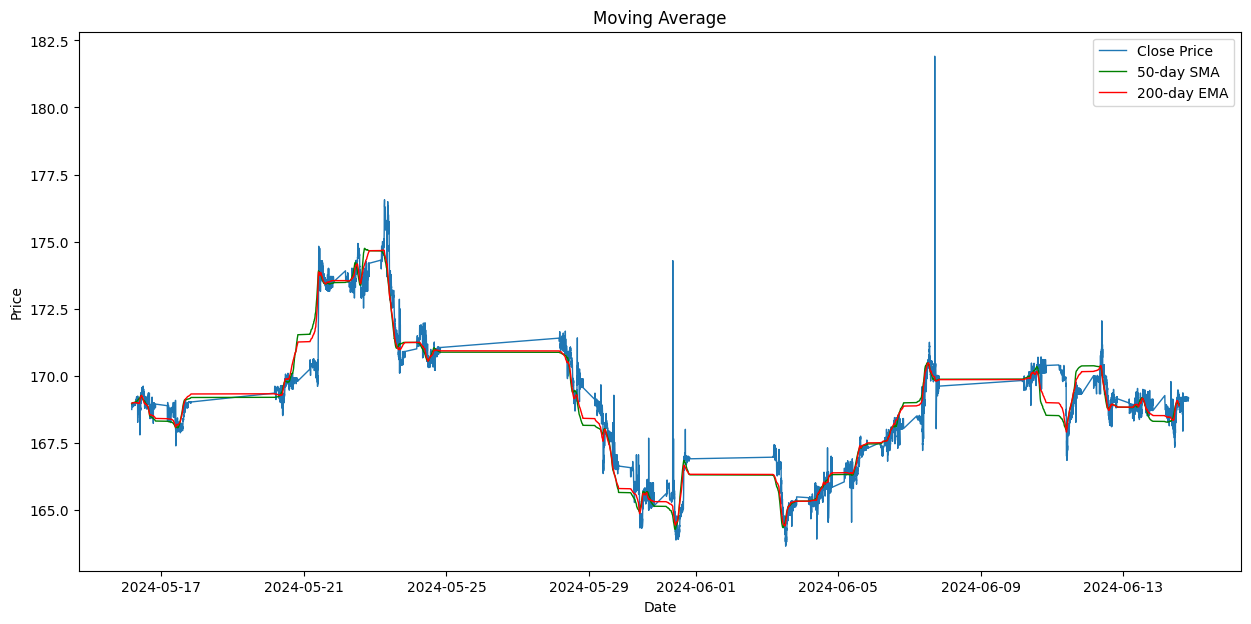

In [51]:
plt.figure(figsize=(15,7))
# Set the title and axis labels
plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')

plt.plot(df['Close'],lw=1, label='Close Price')
plt.plot(sma,'g',lw=1, label='50-day SMA')
plt.plot(ewma,'r', lw=1, label='200-day EMA')

plt.legend()

plt.show()

# Money Flow Index

In [52]:
def gain(x):
    return ((x > 0) * x).sum()


def loss(x):
    return ((x < 0) * x).sum()


# Calculate money flow index
def mfi(high, low, close, volume, n=14):
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign

    # Calculate gain and loss using vectorized operations
    positive_mf = np.where(signed_mf > 0, signed_mf, 0)
    negative_mf = np.where(signed_mf < 0, -signed_mf, 0)

    mf_avg_gain = pd.Series(positive_mf).rolling(n, min_periods=1).sum()
    mf_avg_loss = pd.Series(negative_mf).rolling(n, min_periods=1).sum()

    return (100 - 100 / (1 + mf_avg_gain / mf_avg_loss)).to_numpy()

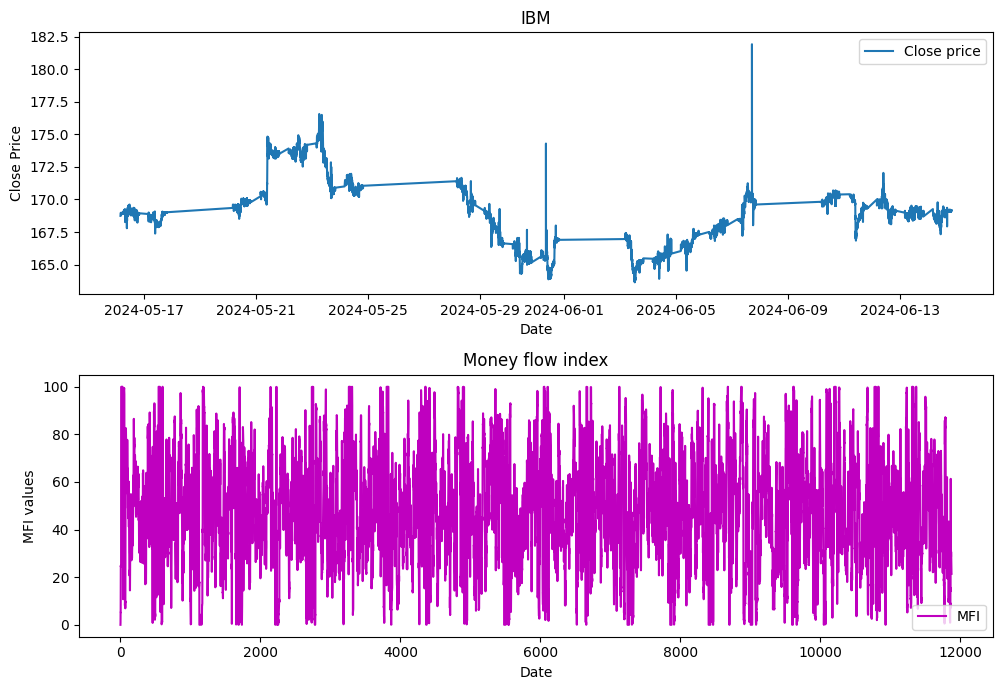

In [53]:
mfi = mfi(df['High'], df['Low'], df['Close'], df['Volume'], 14)

fig = plt.figure(figsize=(10, 7))

# Define position of 1st subplot
ax = fig.add_subplot(2, 1, 1)

# Set the title and axis labels
plt.title('IBM')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.plot(df['Close'], label='Close price')

# Add a legend to the axis
plt.legend()

# Define position of 2nd subplot
bx = fig.add_subplot(2, 1, 2)

# Set the title and axis labels
plt.title('Money flow index')
plt.xlabel('Date')
plt.ylabel('MFI values')

plt.plot(mfi, 'm', label='MFI')

# Add a legend to the axis
plt.legend()

plt.tight_layout()
plt.show()